# GADMA with custom model (momi)

GADMA could be run with a detailed specified demographic model. Model should be provided as a file with a function ``model_func`` that describes demographic history by engine itself. In case of ``momi`` engine function should take values of parameters and return ``momi``'s demographic model.

In this example we will take data and custom demographic model and infer parameters with usage of GADMA and ``momi`` engine.

## Data

We will infer the demographic history of three classical modern human populations:

* YRI - African population (Yorubans),
* CEU - European population (Utah Residents (CEPH) with Northern and Western European Ancestry),
* CHB - Asian population (Han Chinese in Beijing, China).

Data will be taken from VCF file. ``momi`` engine can read any type of SFS data including data for ``dadi`` and ``fastsimcoal2``. However, opposite to ``dadi`` and ``moments`` ``momi`` engine requires full SFS data without any downsizing. That is why it is better to read the SFS data directly from VCF.

Our data includes SNP's on 22 chromosome and was simulated with ``stdpopsim`` using ``msprime`` engine under the demographic history from Gutenkunst et al. 2009. Two individuals for each population are observed.

- `out_of_africa_chr22_sim.vcf` - VCF file with chr22.
- `out_of_africa_chr22_sim.popmap` - file with (sample-population) correspondence.

## Demographic model

Demographic model is located in ``demographic_model.py`` and is written according to [``momi`` manual](https://momi2.readthedocs.io/en/latest/).

It is important to note that units of parameters for ``momi`` engine are `physical` by default. Time for one generation should be equal to 1 and time should be in generations. If we want to mark that one parameter is in `genetic` units then we add `_gen` at the end of its name (e.g. `nu_2F_gen`).

Time parameters should be used (like usually in ``dadi``) as time of epochs. This means that past events should occur in sum of several time parameters (as time of ancestral population split happened at moment T2+T3).

In [1]:
%%bash
cat demographic_model.py

import momi
import numpy as np

def model_func(params):
    """
    N_anc: Ancestral population size
    N_1F: Size of ancestral population after growth and YRI population
    N_2B: Bottleneck size of Eurasian population
    nu_2F_gen: Final size of CEU population (in genetic units)
    r2: Growth rate for CEU population
    N_3F: Final size of CHB population
    r3: Growth rate for CHB population
    T1: Time of epoch between ancestral size growth and first split
    T2: Time of second epoch between two splits
    T3: Time of last epoch, time of last split 
    """
    N_Anc, N_1F, N_2B, nu_2F_gen, r2, N_3F, r3, T1, T2, T3 = params

    model = momi.DemographicModel(N_e=1e5)

    # momi2 uses backward in time models
    # 1. Set leafs at time = 0
    model.add_leaf("YRI", N=N_1F)
    # we have nu_2F_gen is in genetic units so we translate it
    model.add_leaf("CEU", N=nu_2F_gen * N_Anc, g=r2)
    model.add_leaf("CHB", N=N_3F, g=r3)

    # 2. Merge CHB to CEU (T3 time ago) and set siz

We could use some random parameters to plot this demographic model with ``momi``:

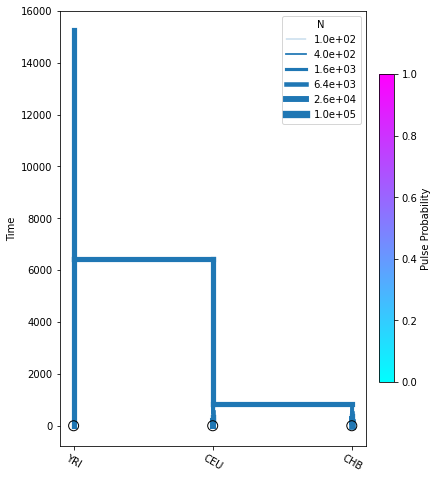

In [2]:
from demographic_model import model_func
import momi
rand_pars = [7300, 12300, 2100, 4, 0.004, 54090, 0.0055, 8800, 5600, 848]
model = model_func(rand_pars)
fig = momi.DemographyPlot(
    model, ["YRI", "CEU", "CHB"],
    figsize=(6,8)
)

## Inference with GADMA

To run GADMA with custom model one should set parameters file:

In [3]:
%%bash
cat params_file

# Set data first
Input file: out_of_africa_chr22_sim.vcf, out_of_africa_chr22_sim.popmap

# Output folder. It should be empty.
Output directory: gadma_result


# Set engine for simulations. We use momi.
Engine: momi

# For engine momi mutation rate and sequence length are required
Mutation rate: 1.29e-8
Sequence length: 51304566

# Now set our custom demographic model from file.
# There should be a function model_func in the file with a model.
Custom filename: demographic_model.py

# for short example
global_maxiter: 30
local_maxiter: 2

# How many repeats to run and how many processes to use.
Number of repeats: 2
Number of processes: 2


In [4]:
%%bash
# As output directory should be empty we remove it if it exists
rm -rf gadma_result

Now we can run GADMA:

In [5]:
%%bash
gadma -p params_file

Data reading
Number of populations: 3
Projections: [4, 4, 4]
Population labels: ('YRI', 'CEU', 'CHB')
Outgroup: True
--Successful data reading--

--Successful arguments parsing--

Parameters of launch are saved in output directory: /home/katenos/Workspace/popgen/temp/GADMA/examples/custom_model_momi/gadma_result/params_file
All output is saved in output directory: /home/katenos/Workspace/popgen/temp/GADMA/examples/custom_model_momi/gadma_result/GADMA.log

--Start pipeline--
Run launch number 1
Run launch number 2

[000:01:00]
All best by log-likelihood models
Number	log-likelihood	Model
Run 2	-244949.17	(N_Anc=192820.74841,	N_1F=7223.22565,	N_2B=346.23931,	nu_2F_gen=0.23018,	r2=6e-05,	N_3F=2552.33854,	r3=-3.98e-04,	T1=495272.96232,	T2=2424.316,	T3=114.44749)	mmmmmmm	
Run 1	-247290.30	(N_Anc=8599.06242,	N_1F=14879.82964,	N_2B=17816.44499,	nu_2F_gen=2.78733,	r2=0.001,	N_3F=2011.56609,	r3=-1.56e-04,	T1=805.41691,	T2=5827.67398,	T3=64.43284)	mmmmmm	
Run 2 warning: failed to draw model due 

[W::vcf_parse] INFO 'AA' is not defined in the header, assuming Type=String
[W::vcf_parse] FILTER 'NOTPASS' is not defined in the header


It is just a start of optimization as numer of iterations is limited to 30 but we can see that size of ancestral population is similar to 7300 that was used for simulation. We can evaluate value of log-likelihood on simulated values:

In [6]:
# load data
ind2pop = {'tsk_0': 'YRI', 'tsk_1': 'YRI', 'tsk_2': 'CEU', 'tsk_3': 'CEU', 'tsk_4': 'CHB', 'tsk_5': 'CHB'}
data = momi.SnpAlleleCounts.read_vcf('out_of_africa_chr22_sim.vcf', ind2pop=ind2pop).extract_sfs(n_blocks=100)
data = data.subset_populations(['YRI', 'CEU', 'CHB'])

# evaluate log likelihood
model.set_data(data, length=51304566)
ll_model = model.log_likelihood()
print(f'Value of log-likelihood on values used in simulation: {ll_model}')

No BED provided, will need to specify length manually with mutation rate


Value of log-likelihood on values used in simulation: -249931.26661084342
